# Beta / Kumaraswamy Oracle Consensus Algorithms

In [1]:
import numpy as np
from typing import List, Tuple
import seaborn as sns
import matplotlib.pyplot as plt

## Sample Data

In [65]:
def generate_beta_oracles(N_oracles, N_failing_oracles, a : float, b : float):
    oracles = [
        (np.random.beta(a, b), True)
        if i >= N_failing_oracles 
        else (np.random.uniform(0, 1), False)
        for i in range(N_oracles)
    ]

    np.random.shuffle(oracles)
    disjoint = tuple(map(list, zip(*oracles)))
    return disjoint

def generate_2d_beta_oracles(N_oracles, N_failing_oracles, a : Tuple[float], b : Tuple[float]):
    oracles = [
        (np.array([
            np.random.beta(a[0], b[0]),
            np.random.beta(a[1], b[1])
            ]), True)
        if i >= N_failing_oracles 
        else (np.array([
            np.random.uniform(0, 1),
            np.random.uniform(0, 1) 
            ]), False)
        for i in range(N_oracles)
    ]

    np.random.shuffle(oracles)
    # disjoint = tuple(map(list, zip(*oracles)))
    
    values, validity = zip(*oracles)

    return np.array(values), np.array(validity)

In [75]:
def beta_mode(a : float, b : float) -> float:
    return ((a - 1) / (a*b - 1)) ** (1 / a)

#### Typical data

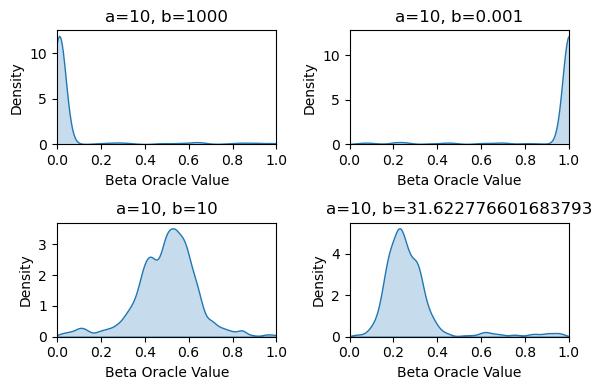

In [85]:
def plot_oracles_density(N_oracles, N_failing_oracles, a1, a2, a3, a4, b1, b2, b3, b4):
    # Generate oracles for each combination of true essence and true sigma
    oracles_sets = [
        generate_beta_oracles(N_oracles, N_failing_oracles, a1, b1),
        generate_beta_oracles(N_oracles, N_failing_oracles, a2, b2),
        generate_beta_oracles(N_oracles, N_failing_oracles, a3, b3),
        generate_beta_oracles(N_oracles, N_failing_oracles, a4, b4)
    ]

    # Set up the matplotlib figure with 4 subplots
    fig, axes = plt.subplots(2, 2, figsize=(6, 4))
    axes = axes.flatten()

    # Titles for each subplot
    titles = [
        f'a={a1}, b={b1}',
        f'a={a2}, b={b2}',
        f'a={a3}, b={b3}',
        f'a={a4}, b={b4}'
    ]

    # Plot each oracle set
    for i, (oracles, true_oracles) in enumerate(oracles_sets):
        oracle_values = np.array(oracles)
        sns.kdeplot(oracle_values, bw_adjust=0.5, fill=True, ax=axes[i])
        axes[i].set_xlim(0, 1)
        axes[i].set_title(titles[i])
        axes[i].set_xlabel('Beta Oracle Value')
        axes[i].set_ylabel('Density')

    plt.tight_layout()
    plt.show()

a = 10
a1, a2, a3, a4 = a, a, a, a
b1, b2, b3, b4 = a**(3), a**(-3), a, a**1.5, 
plot_oracles_density(500, 60, a1, a2, a3, a4, b1, b2, b3, b4)


### Samples for the Algorithm

In [89]:
N_oracles = 20
failing_percentage = 0.2
N_failing_oracles = round(N_oracles * failing_percentage)

In [90]:
a = 10

b_1d = 1
b_2d = [15, 30]

oracles, true_oracles = generate_beta_oracles(N_oracles, N_failing_oracles, a, a)
oracles_2d, true_oracles_2d = generate_2d_beta_oracles(
    N_oracles, N_failing_oracles, [a, a], [15, 15])

true_essence_1d = beta_mode(a, b_1d)
true_essence_2d = (beta_mode(a, b_2d[0]), beta_mode(a, b_2d[1]))

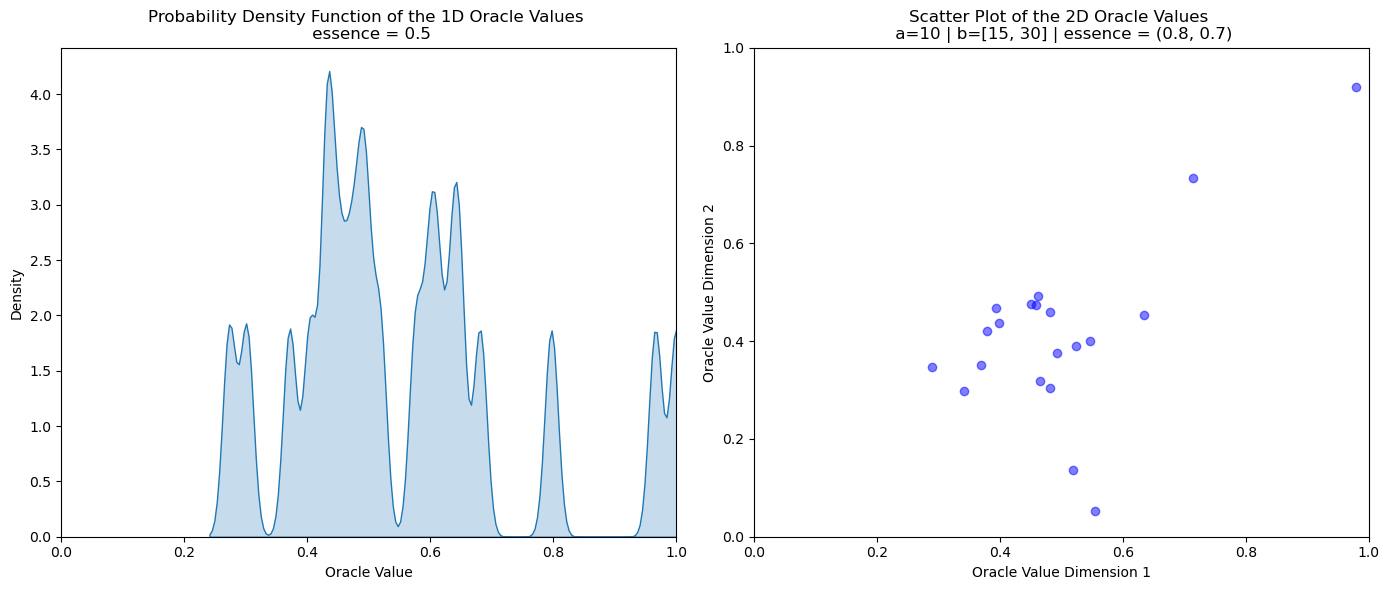

In [91]:
def plot():
    oracle_values = np.array(oracles)
    oracle_values_2d = oracles_2d
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    sns.kdeplot(oracle_values, bw_adjust=0.1, fill=True, ax=axs[0])
    axs[0].set_xlim(0, 1)
    axs[0].set_title('Probability Density Function of the 1D Oracle Values \n essence = 0.5')
    axs[0].set_xlabel('Oracle Value')
    axs[0].set_ylabel('Density')
    
    axs[1].scatter(oracle_values_2d[:, 0], oracle_values_2d[:, 1], c='b', alpha=0.5)
    axs[1].set_xlim(0, 1)
    axs[1].set_ylim(0, 1)

    string_2d_essence = f'({true_essence_2d[0]:0.01f}, {true_essence_2d[1]:0.01f})'
    axs[1].set_title(f'Scatter Plot of the 2D Oracle Values \n a={a} | b={b_2d} | essence = {string_2d_essence}')
    axs[1].set_xlabel('Oracle Value Dimension 1')
    axs[1].set_ylabel('Oracle Value Dimension 2')
    
    plt.tight_layout()
    plt.show()

plot()

## Algorithm to find the mode